# lab 7

# Supermodeling

## What is supermodeling

![](images/architecture.png)

source: Complex Systems Lecture

## Submodels

![](images/like_neuron.png)

source: Complex Systems Lecture

![](images/explanation.png)

source: Complex Systems Lecture

## Lorenz again

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

### Utilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from data_assimilation import assimilate_lorenz, assimilate_lorenz_weighted
%matplotlib inline

In [69]:
def plot_models_coords_in_time(models, timelines):
    f, (px, py, pz) = plt.subplots(3, 1, sharex=True, figsize=(15,8))

    px.set_ylabel("X component")
    py.set_ylabel("Y component")
    pz.set_ylabel("Z component")
    
    for ix, (model, timeline) in enumerate(zip(models, timelines)):
        px.plot(timeline, model[:,0], lw=0.5)
        py.plot(timeline, model[:,1], lw=0.5)
        pz.plot(timeline, model[:,2], lw=0.5, label=str(ix+1))

    pz.set_xlabel("Time index (x 100)")
    
    f.legend(title="Models in order")
    

def plot_models(models, timelines=None, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
            ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten(), lw=0.5)
    plt.draw()
    plt.show()
    
    if timelines is not None:
        plot_models_coords_in_time(models, timelines)
    
def plot_model(model, timeline=None, figsize=(5,5)):
    if timeline is not None:
        return plot_models([model],[timeline],figsize)
    return plot_models([model],figsize=figsize)

    
def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(lorenz_models.shape[1])])


def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])

def lorenz_step(coords, parameters, dt=0.01):
    rho, sigma, beta = parameters
    x, y, z = coords
    return coords + (np.multiply(np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z]), dt))

def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0/3.0, start_time=0.0, number_of_samples=4000, dt=0.01, plot=False):
    size = number_of_samples
    
    if start_time:
        size += ceil(start_time/dt)

    coords = np.empty([size,3])

    coords[0] = [x,y,z]
    parameters = [rho, sigma, beta]
    for i in range(size - 1):
        coords[i+1] = lorenz_step(coords[i],parameters, dt=dt)
    coords = coords[-number_of_samples:]
    if plot:
        plot_model(coords)
    return coords, np.arange(start_time, start_time + number_of_samples * dt, dt)
    
    
def lorenz_research(
    start_time = 0,
    number_of_samples = 200,
    steps_4dvar = 50,
    small_plot = True,
    full_plot = True,
    initial_params = None
):
    l63_gt, l63_timeline_gt = generate_lorenz(
        start_time=start_time, 
        number_of_samples=number_of_samples
    )
    
    
    initial = dict(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma = 10.0,
        rho = 20.,
        beta = 5.
    )
    
    if initial_params is not None:
        initial.update(initial_params)
    
    error_vector = [0.1, 0.1, 0.1, 100, 100, 100]
    
    coords_and_params = assimilate_lorenz(
        initial, 
        l63_gt,
        lorenz_step, 
        maximum_number_of_steps=steps_4dvar,
        verbose=True, 
        error_vector=error_vector
    )
    l63_4dv, l63_4dv_timeline = generate_lorenz(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma=coords_and_params['sigma'],
        rho=coords_and_params['rho'],
        beta=coords_and_params['beta'],
        number_of_samples=number_of_samples
    )
    
    if small_plot:
        plot_models(
            [l63_gt, l63_4dv],
            [l63_timeline_gt, l63_timeline_gt]
        )
    
    
    full_lorenz, fl_timeline = generate_lorenz()
    full_predicted, full_pred_timeline = generate_lorenz(sigma=coords_and_params['sigma'],rho=coords_and_params['rho'],beta=coords_and_params['beta'])
        
    if full_plot:
        plot_models([full_lorenz, full_predicted], [fl_timeline, full_pred_timeline])
        
    return {
        'partial': {
            'gt': [l63_gt, l63_timeline_gt],
            'pred': [l63_4dv, l63_4dv_timeline],
        },
        'full': {
            'gt': [full_lorenz, fl_timeline],
            'pred': [full_predicted, full_pred_timeline],
        }
    }

def set_submodel_consts(
    number_of_samples = 200,
    steps_4dvar = 20
):    
    def create_submodel(sigma, rho, beta, start_time = 4.5):
            
        return lorenz_research(    
            start_time = start_time,
            number_of_samples = number_of_samples,
            steps_4dvar = steps_4dvar,
            small_plot = True,
            full_plot = False,
            initial_params = dict(sigma=sigma,rho=rho,beta=beta)
        )

    return create_submodel

def error_metric(ground_truth, our_result):
    return np.mean([sum(abs(np.subtract(*k)))/(i+1) for i, k in enumerate(zip(ground_truth, our_result))])

## Task 1. Choose a fragment of Lorenz 63

In the first task you have to sample a chosen part of Lorenz attractor.
Remember that the attractor uses time so in other word `models_start` variable is a time from which we start sampling.
Keep in mind that `number_of_samples = 200` is maximum value for reasonably timed computation in future tasks, do don't change it.

In [9]:
# TODO: find fancy, not too long trajectory of L63
model_start = 0

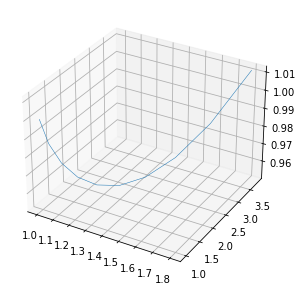

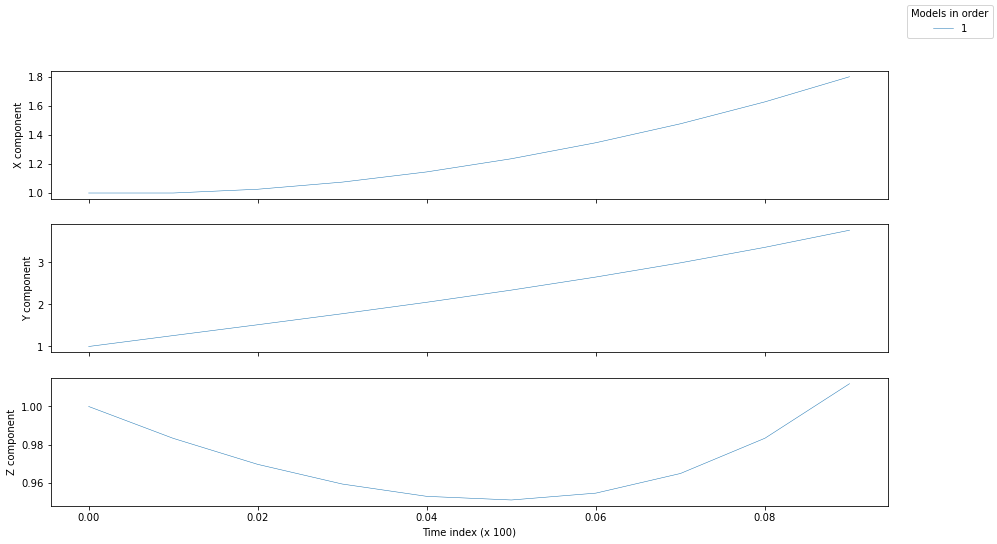

In [10]:
l63, l63_timeline = generate_lorenz(
    start_time=model_start, 
    number_of_samples=10
)
plot_model(l63, l63_timeline)

## Task 2. Have fun with 4dvar

So you know how to sample L63 trajectory. Now you will use 4D-Var to predict Lorenz64 parameters.
Find out how many samples are needed so we can say that the prediction is satisfying enough. As stated before, `number_of_samples` should be less than `200`, otherwise the prediction would have taken too much time.
Try few options each one in new cell so you can compare your results. \
TIP: play on range [5, 200]. \
Put `;` on the end of the method, it disables auto printing of returned value.

  Intermediate CurrentState at the current iteration: [ 1.  1.  1. 20. 10.  5.]
  Intermediate CurrentState at the current iteration: [ 1.64475722  1.76060675  1.06080918 20.04411502 10.00955922  4.99450086]
  Intermediate CurrentState at the current iteration: [ 1.18997542  1.22411008  1.01791721 20.01299833 10.00281659  4.9983797 ]
  Intermediate CurrentState at the current iteration: [ 1.18152702  1.23152999  1.03162057 20.01620771 10.00269848  4.99725196]
  Intermediate CurrentState at the current iteration: [ 1.11859226  1.28699731  1.08185632 20.04770229 10.0019385   4.98928602]
  Intermediate CurrentState at the current iteration: [ 1.10385227  1.29925735  1.07861199 20.07000928 10.0020782   4.98509538]
  Intermediate CurrentState at the current iteration: [ 1.08242843  1.31415082  1.07433251 20.15603936 10.00345865  4.96826828]
  Intermediate CurrentState at the current iteration: [ 1.04341409  1.33343989  1.06630207 20.46385076 10.00939808  4.90737749]
  Intermediate CurrentSt

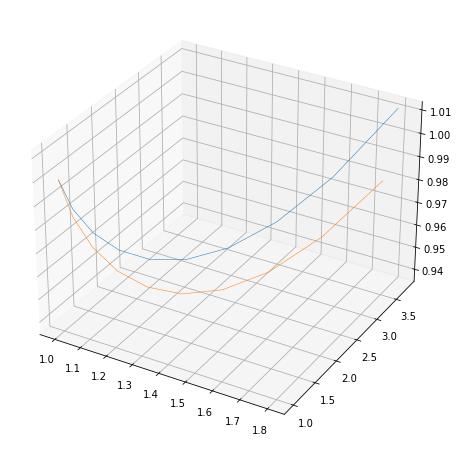

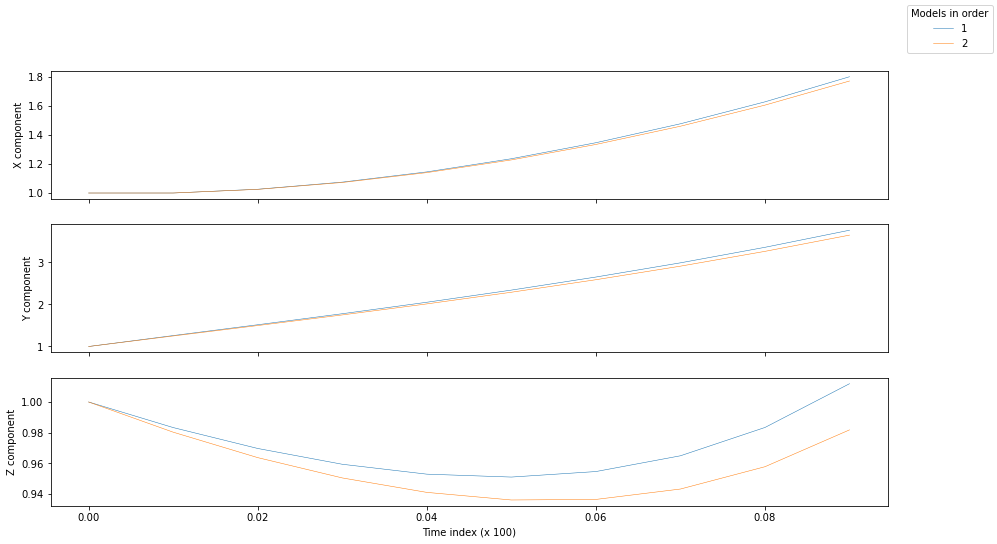

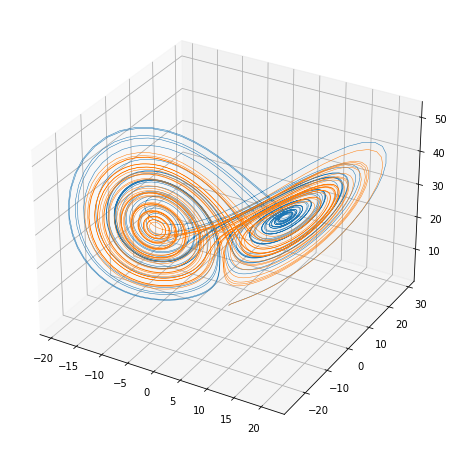

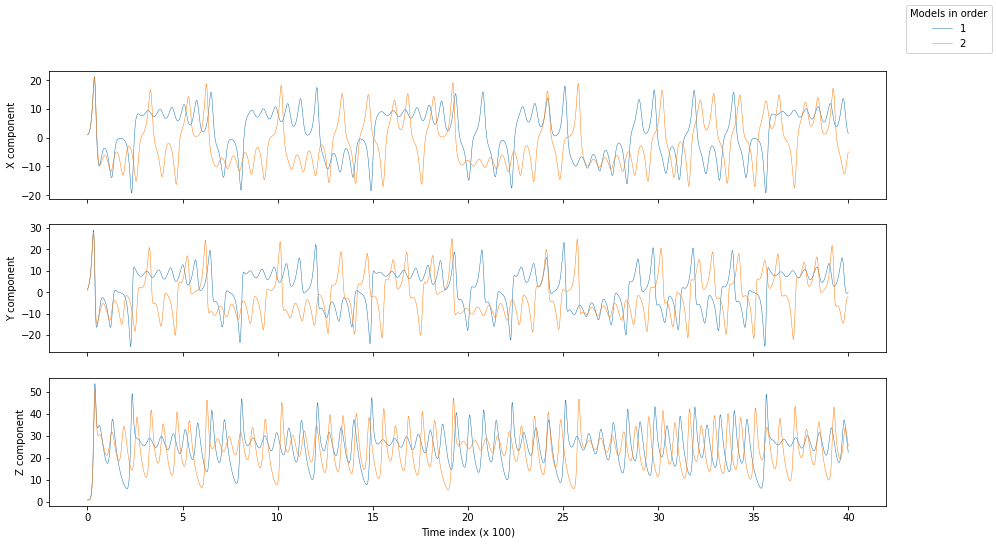

In [12]:
lorenz_research(
    number_of_samples=10,
# TODO: use stating point that you have chossen in previous task
    start_time=0
);

## Task 3. Play with iterations

4D-Var assimilation does iterations and during each one it gets closer to the solution. Try to optimize it, just like samples .


In [42]:
lorenz_research(
    number_of_samples=200,
    steps_4dvar=10,
    start_time=0
);

  Intermediate CurrentState at the current iteration: [ 1.  1.  1. 20. 10.  5.]


KeyboardInterrupt: 

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [1.72429223 0.31143303 0.96427474]
  Intermediate CurrentState at the current iteration: [ 2.70854936 -2.11911849  0.3906323 ]
  Intermediate CurrentState at the current iteration: [ 2.02360654 -0.42770193  0.78982907]
  Intermediate CurrentState at the current iteration: [ 2.00915543 -0.85605232  0.81581543]
  Intermediate CurrentState at the current iteration: [ 2.01870372 -0.57302822  0.79864545]
  Intermediate CurrentState at the current iteration: [ 2.00422336 -0.59209018  0.82599399]
  Intermediate CurrentState at the current iteration: [ 2.00503658 -0.58921907  0.82500796]
  Intermediate CurrentState at the current iteration: [ 2.00509047 -0.58957721  0.82481856]
  Intermediate CurrentState at the current iteration: [ 2.00507873 -0.58957502  0.82484228]
Calibration of 3 coefficients on 30000 measures
--------------------------------------------------------------

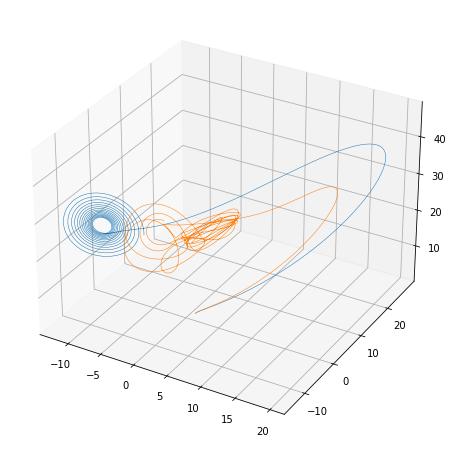

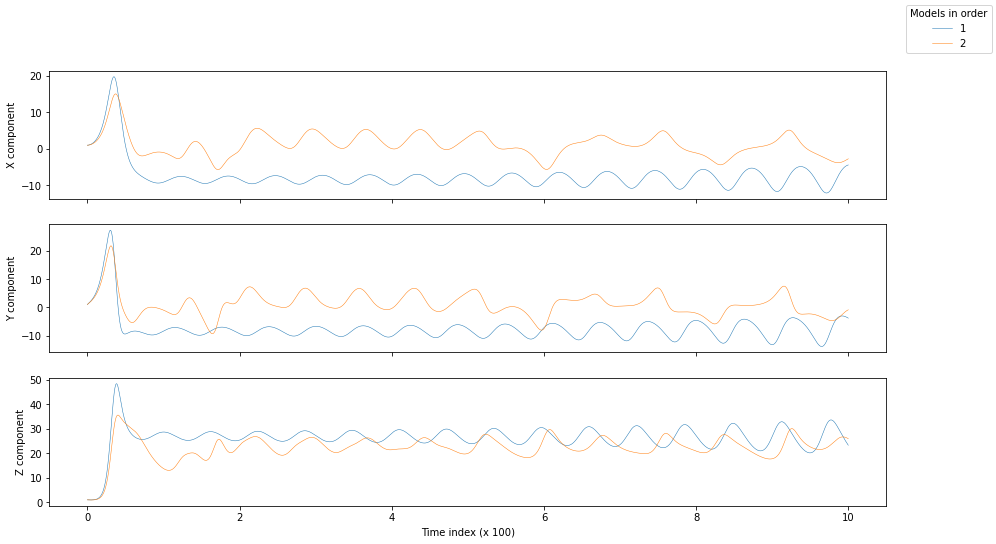

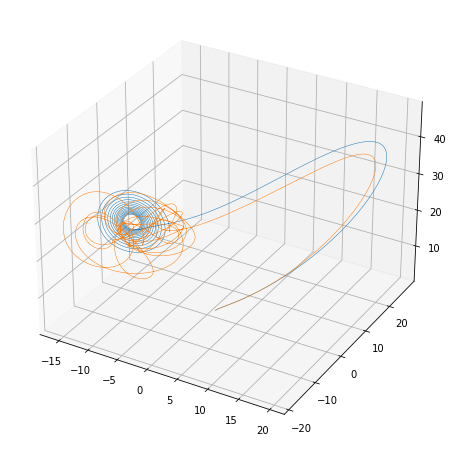

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [1.80655069 0.48669288 0.70675643]
  Intermediate CurrentState at the current iteration: [1.64183015 0.64219924 0.91966867]
  Intermediate CurrentState at the current iteration: [1.65587046 0.63703309 0.90291006]
  Intermediate CurrentState at the current iteration: [1.6583079  0.63563522 0.90034374]
  Intermediate CurrentState at the current iteration: [1.65828672 0.63564441 0.90036891]
Calibration of 3 coefficients on 90000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [1.65828672 0.63564441 0.90036891]
0.001 30
0.003524698228343765
0.0032173470306572837


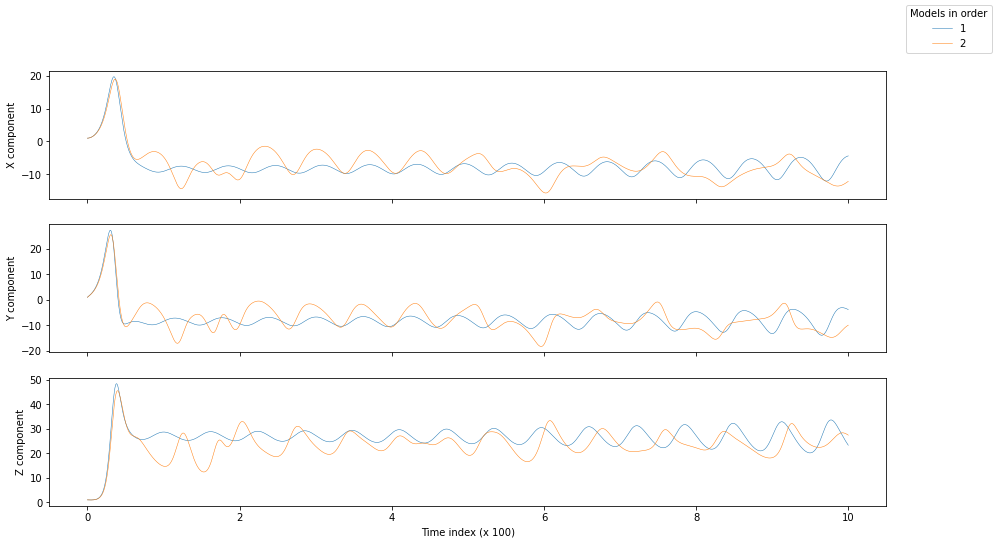

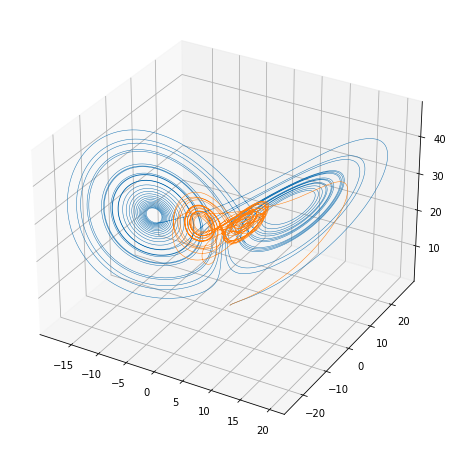

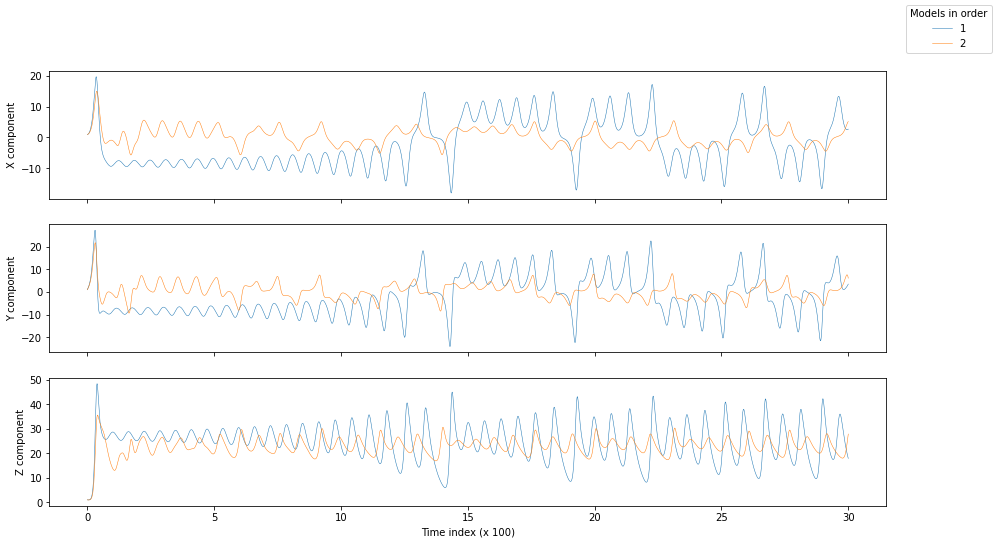

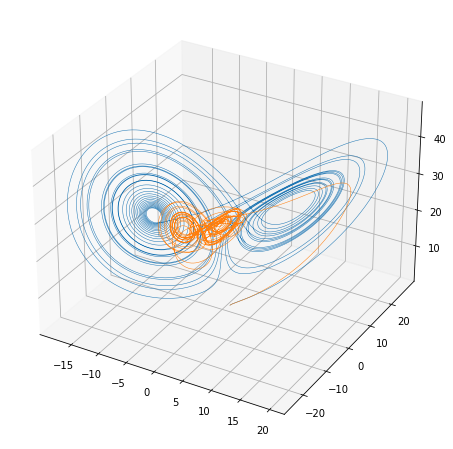

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [1.77390788 0.83843448 0.38765763]
  Intermediate CurrentState at the current iteration: [1.59954439 0.89136026 0.73095741]
  Intermediate CurrentState at the current iteration: [1.61078829 0.88113073 0.72700723]
  Intermediate CurrentState at the current iteration: [1.61445106 0.87625072 0.72695159]
  Intermediate CurrentState at the current iteration: [1.61442304 0.87623138 0.72700009]
Calibration of 3 coefficients on 150000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [1.61442304 0.87623138 0.72700009]
0.001 50
0.0023464624308711297
0.002345150548997412


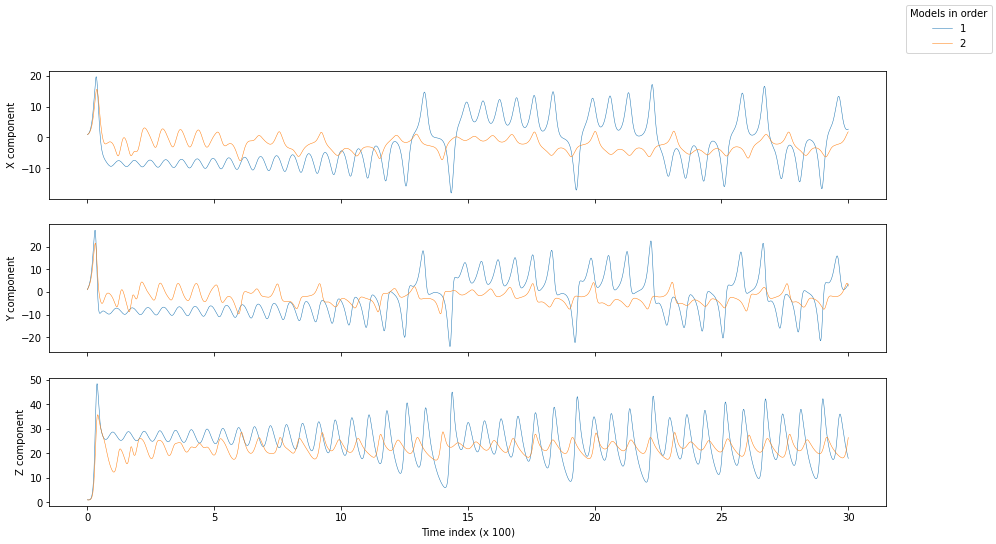

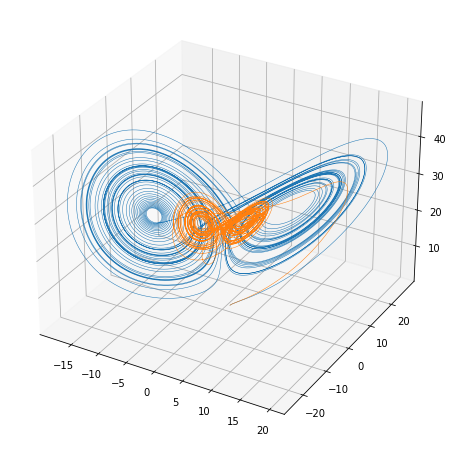

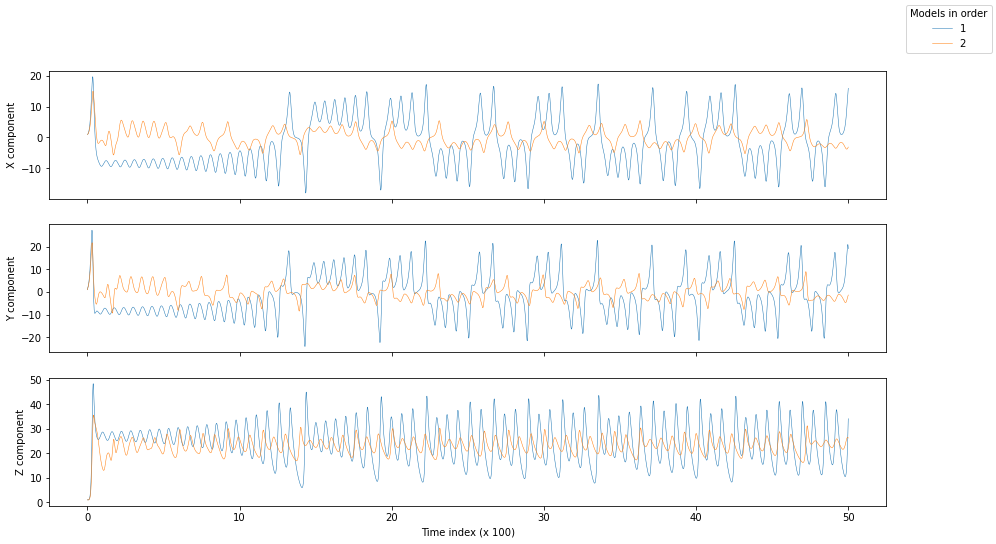

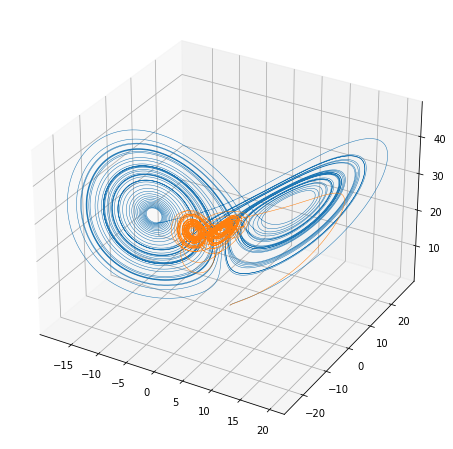

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [0.64013585 0.54520903 1.81465512]
  Intermediate CurrentState at the current iteration: [0.92631079 0.90687267 1.16681654]
  Intermediate CurrentState at the current iteration: [0.9151211  0.9155295  1.16914354]
  Intermediate CurrentState at the current iteration: [0.867432   0.95579857 1.17580925]
  Intermediate CurrentState at the current iteration: [0.86748568 0.95575884 1.17580262]
Calibration of 3 coefficients on 3000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [0.86748568 0.95575884 1.17580262]
0.01 10
0.08303560264628612
0.0804214599696132


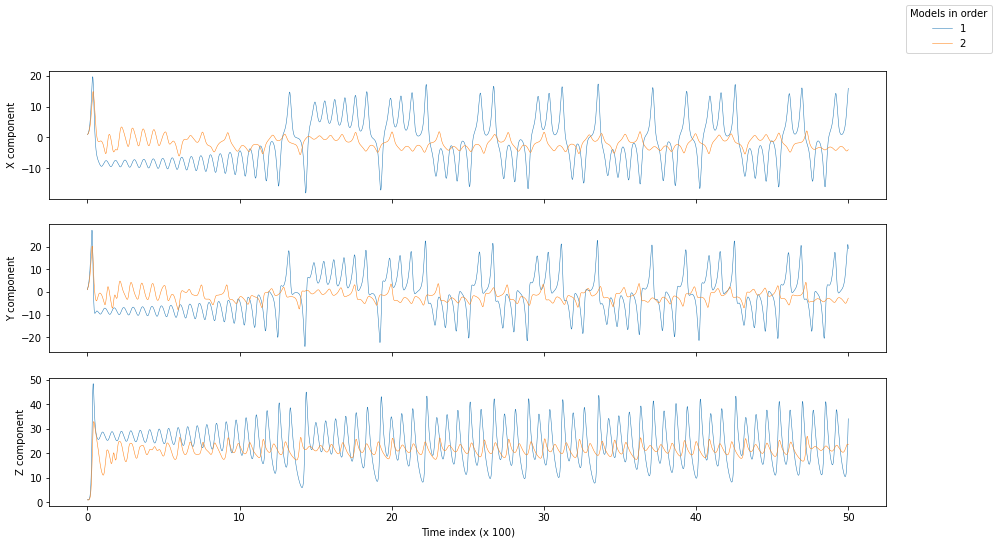

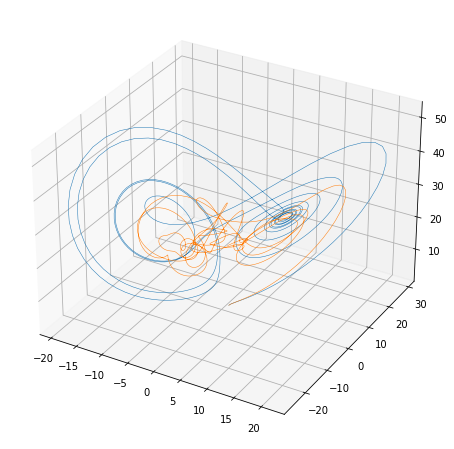

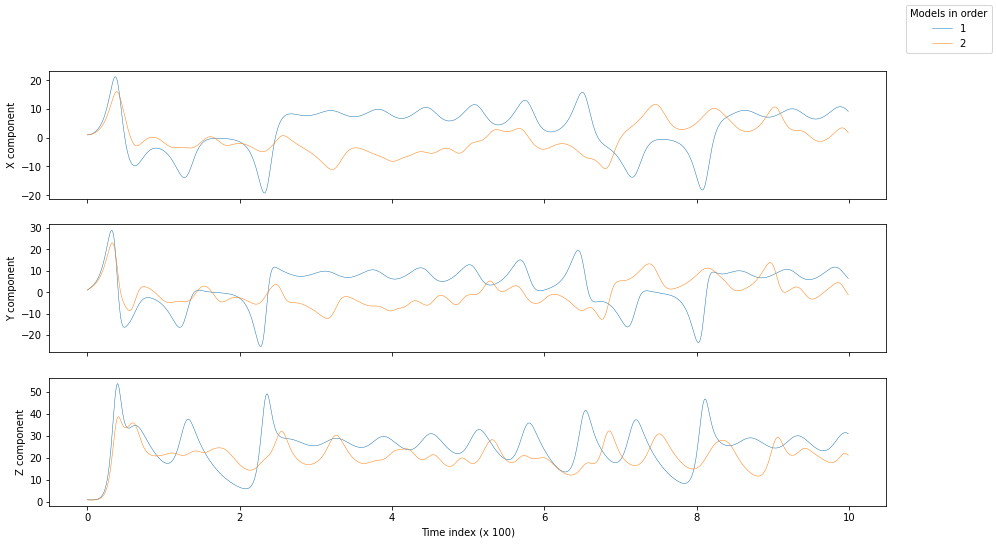

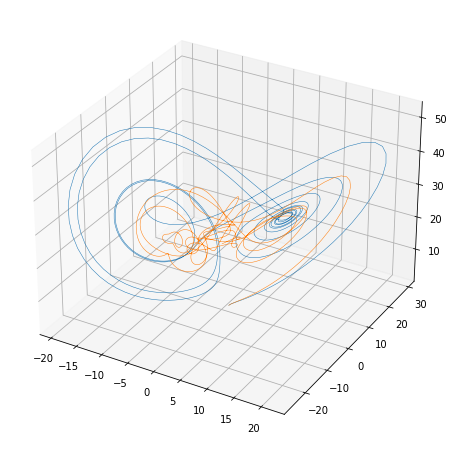

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [0.68065783 0.50889045 1.81045172]
  Intermediate CurrentState at the current iteration: [0.93341354 0.89759809 1.16898837]
  Intermediate CurrentState at the current iteration: [0.93315444 0.89692908 1.16970751]
  Intermediate CurrentState at the current iteration: [0.93324799 0.8968475  1.16969544]
  Intermediate CurrentState at the current iteration: [0.93348742 0.8966525  1.16965396]
  Intermediate CurrentState at the current iteration: [0.93348742 0.8966525  1.16965396]
Calibration of 3 coefficients on 9000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [0.93348742 0.8966525  1.16965396]
0.01 30
0.037101867481536176
0.03603275464185148


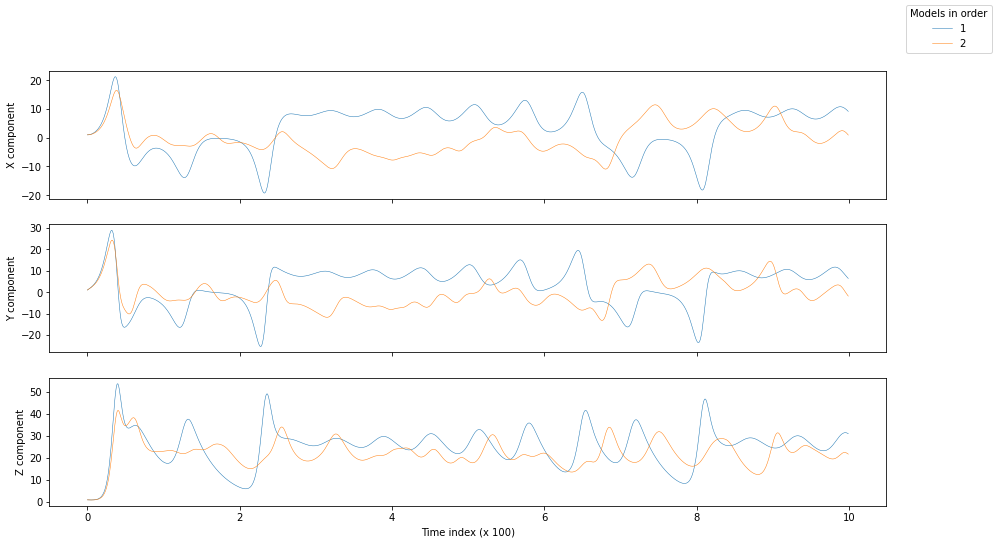

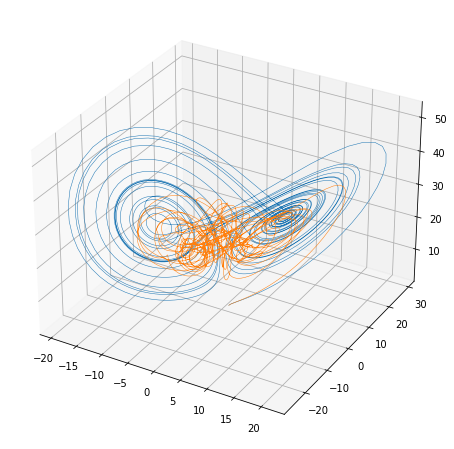

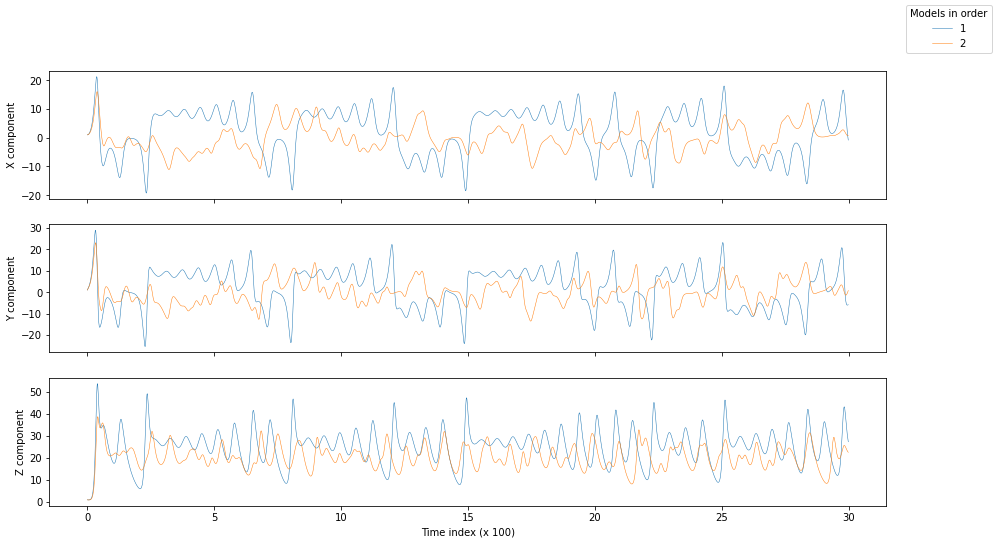

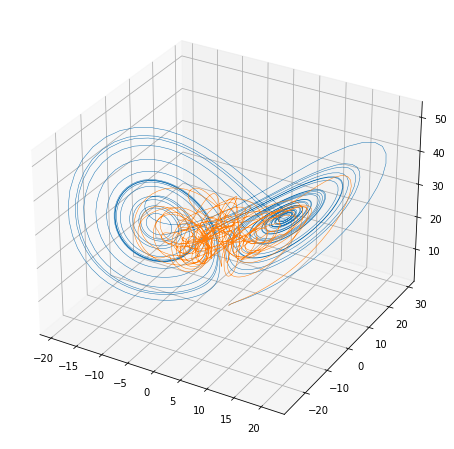

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [0.40815998 0.80879164 1.78304838]
  Intermediate CurrentState at the current iteration: [0.84237955 0.94907687 1.20854358]
  Intermediate CurrentState at the current iteration: [0.78996432 1.00107999 1.20872016]
  Intermediate CurrentState at the current iteration: [0.68071438 1.09301033 1.19852384]
  Intermediate CurrentState at the current iteration: [0.68534978 1.09216672 1.19758587]
  Intermediate CurrentState at the current iteration: [0.6850309  1.0921696  1.19769025]
  Intermediate CurrentState at the current iteration: [0.68502891 1.09217148 1.19768955]
Calibration of 3 coefficients on 15000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [0.68502891 1.09217148 1.19768955]
0.01 50
0.024682590691608195
0.02416212023118218


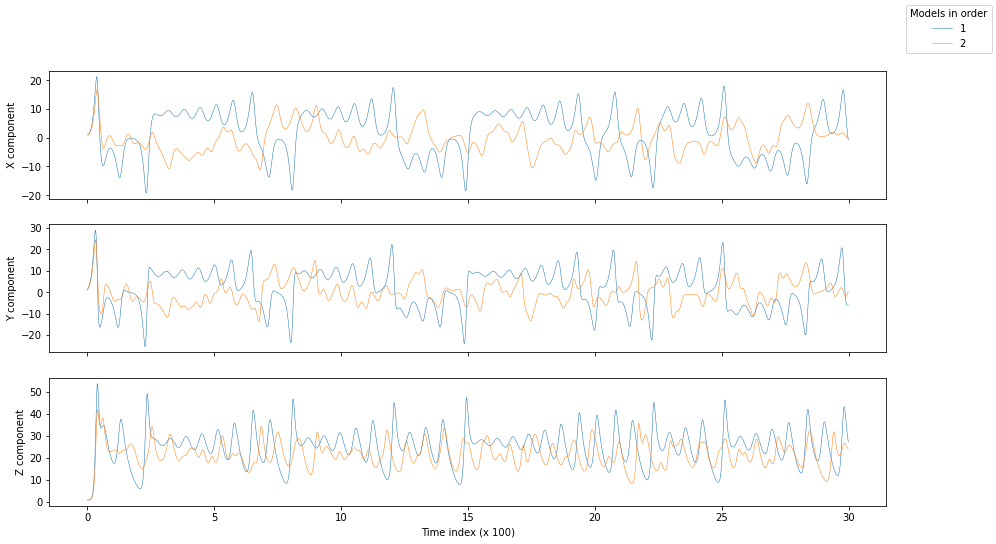

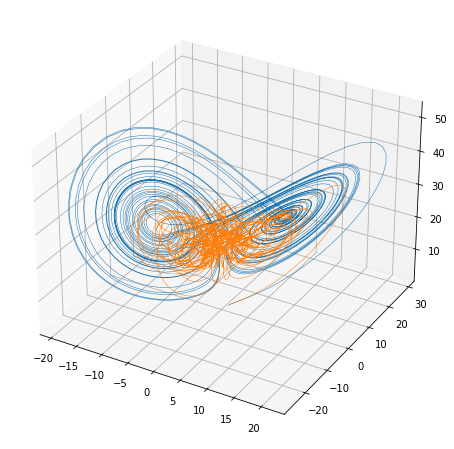

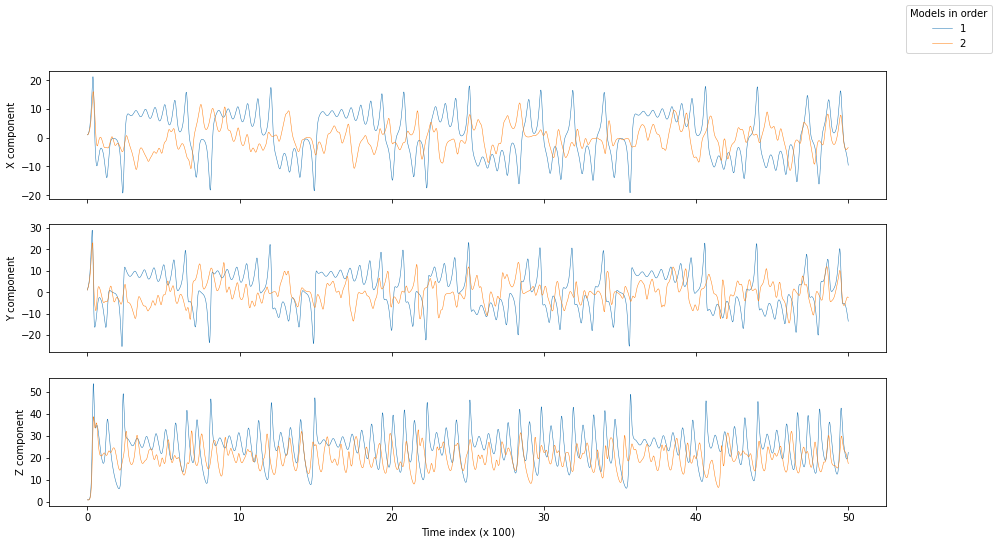

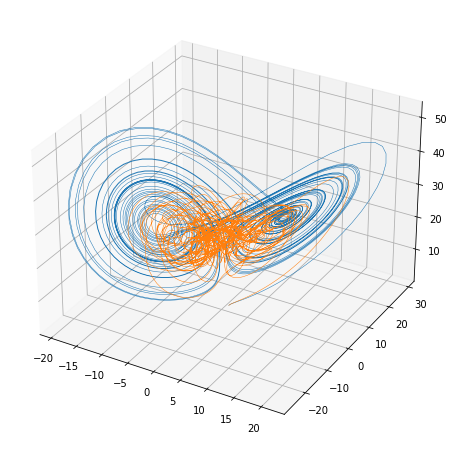

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [0.85350351 0.3776161  1.76888039]
  Intermediate CurrentState at the current iteration: [0.92705718 0.69010564 1.38283719]
  Intermediate CurrentState at the current iteration: [1.00423504 0.62422277 1.37153283]
  Intermediate CurrentState at the current iteration: [1.26649189 0.28571329 1.26177394]
  Intermediate CurrentState at the current iteration: [1.26792998 0.37364097 1.28130612]
  Intermediate CurrentState at the current iteration: [1.2622999  0.35341088 1.28024521]
  Intermediate CurrentState at the current iteration: [1.26319528 0.350665   1.27916383]
  Intermediate CurrentState at the current iteration: [1.26307441 0.35084832 1.27926411]
  Intermediate CurrentState at the current iteration: [1.26307907 0.35084812 1.27926222]
Calibration of 3 coefficients on 1998 measures
---------------------------------------------------------------------
Calibration resul

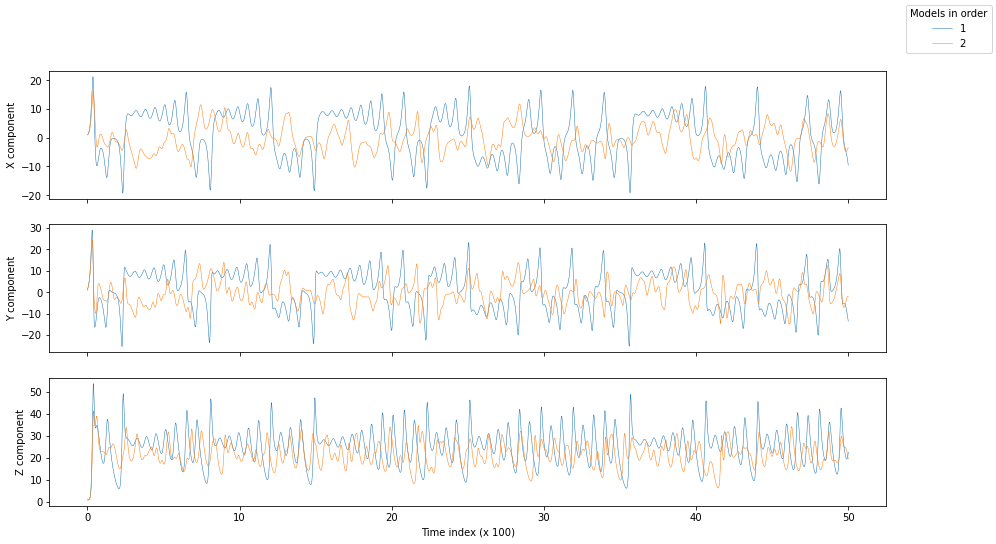

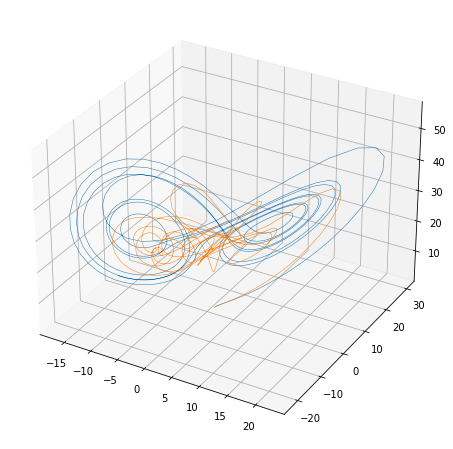

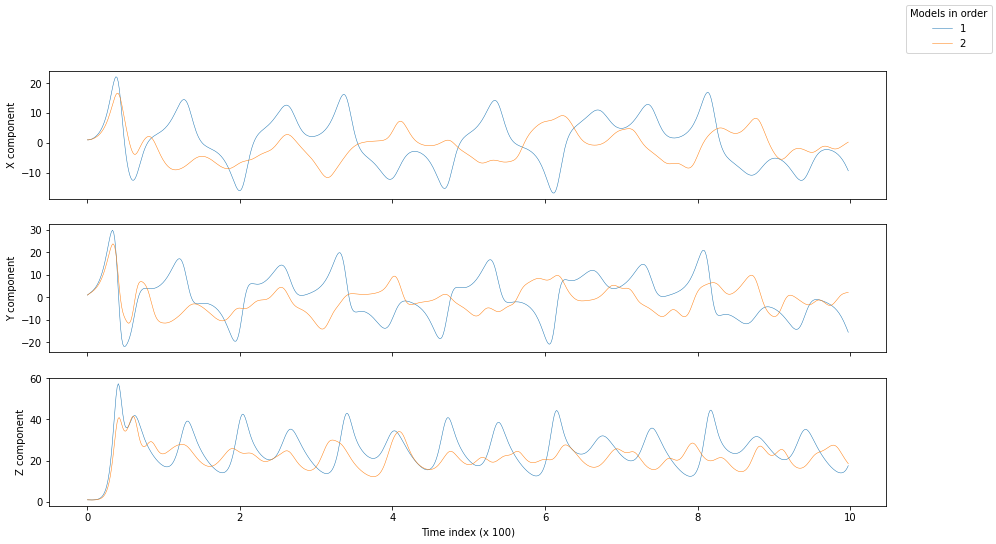

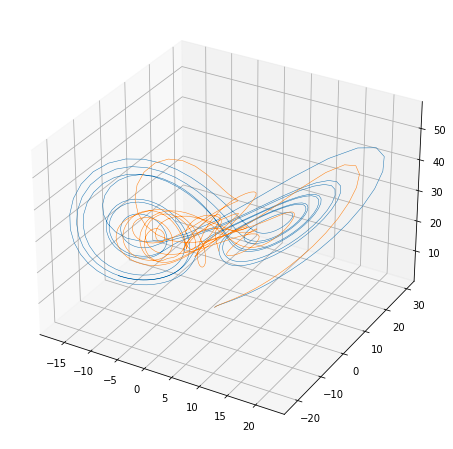

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [0.51105214 0.67817234 1.81077552]
  Intermediate CurrentState at the current iteration: [0.84291441 0.89660556 1.26048003]
  Intermediate CurrentState at the current iteration: [0.80152889 0.93454094 1.26366701]
  Intermediate CurrentState at the current iteration: [0.68448608 1.02659603 1.2613176 ]
  Intermediate CurrentState at the current iteration: [0.68956337 1.02690513 1.26028451]
  Intermediate CurrentState at the current iteration: [0.68905313 1.0267416  1.26045076]
  Intermediate CurrentState at the current iteration: [0.68904791 1.02674487 1.26045014]
Calibration of 3 coefficients on 6000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [0.68904791 1.02674487 1.26045014]
0.015 30
0.058608796991253986
0.05617020545088427


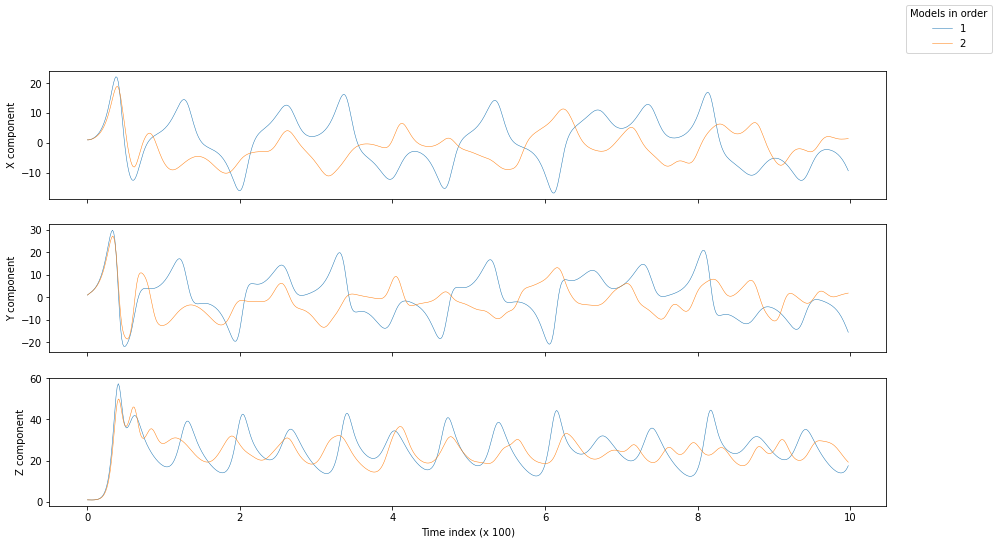

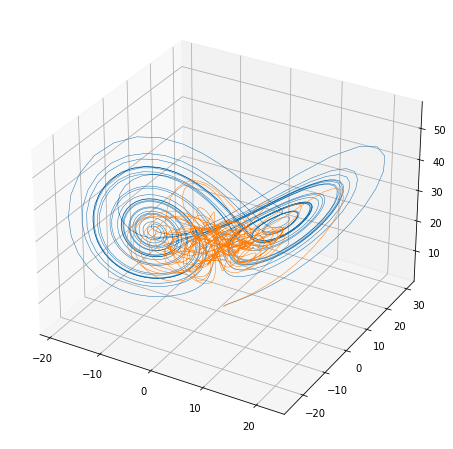

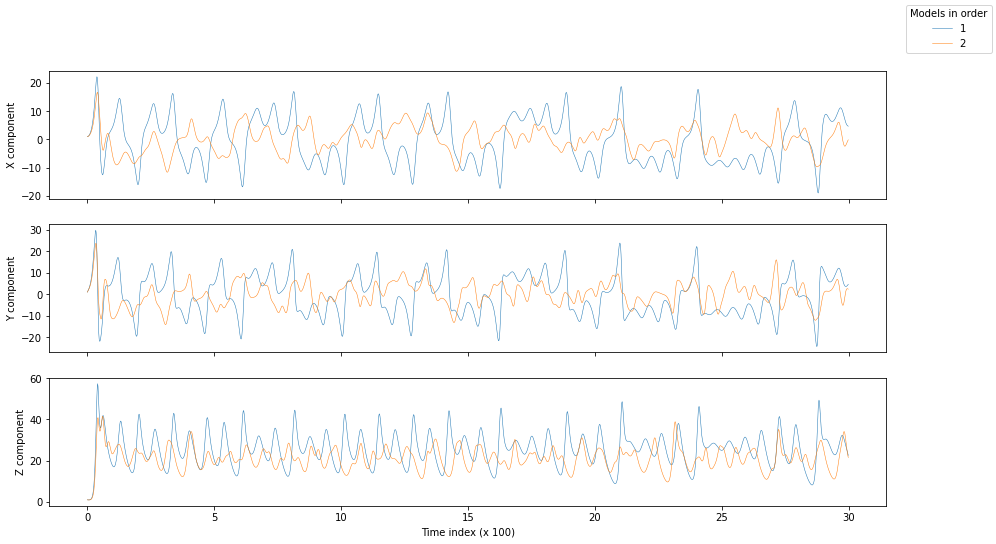

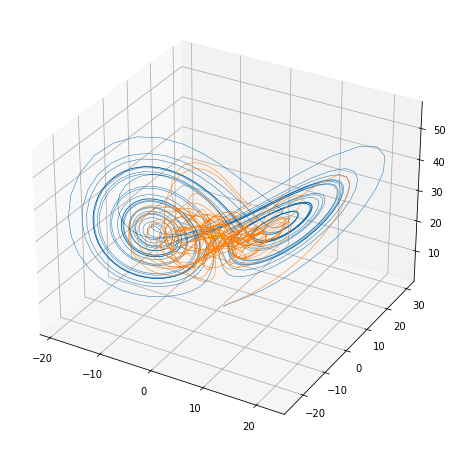

  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [0.51468797 0.67401362 1.81129841]
  Intermediate CurrentState at the current iteration: [0.82470139 0.8822511  1.29304751]
  Intermediate CurrentState at the current iteration: [0.77833538 0.92471583 1.29670262]
  Intermediate CurrentState at the current iteration: [0.65868377 1.01731263 1.29441355]
  Intermediate CurrentState at the current iteration: [0.66462705 1.01795793 1.29320629]
  Intermediate CurrentState at the current iteration: [0.66396109 1.01769981 1.29342566]
  Intermediate CurrentState at the current iteration: [0.66395303 1.01770441 1.29342484]
Calibration of 3 coefficients on 9999 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [0.66395303 1.01770441 1.29342484]
0.015 50
0.03927605796714516
0.037536054874944116


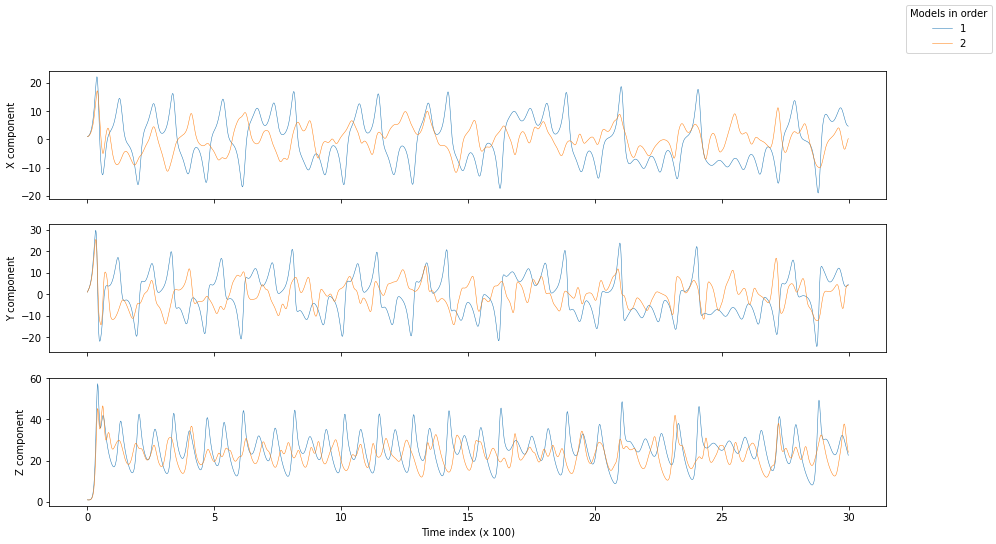

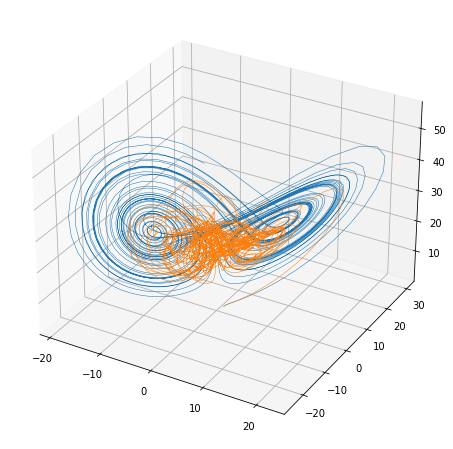

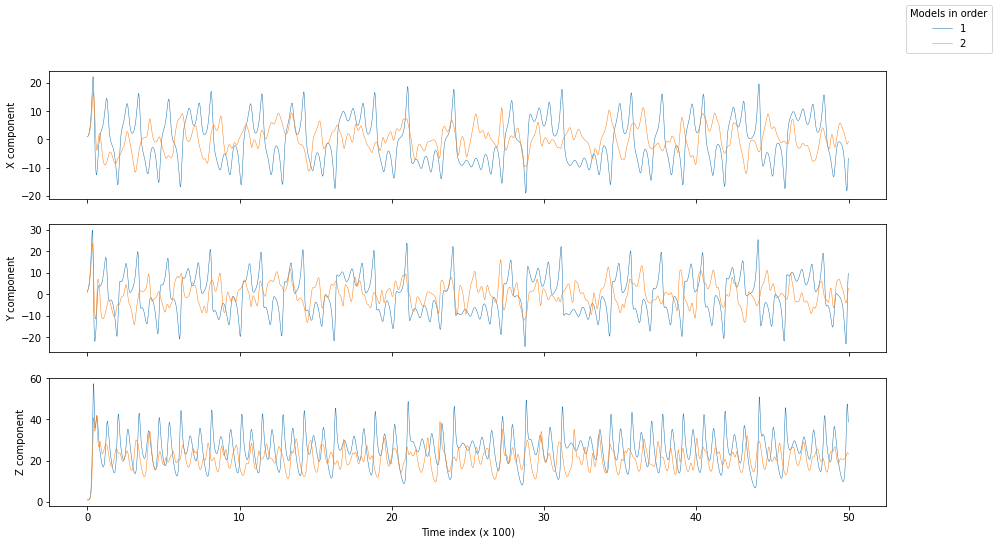

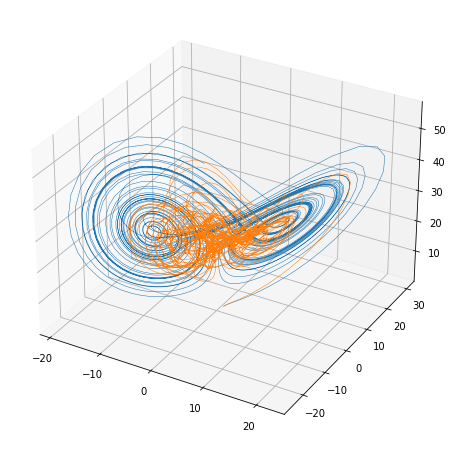

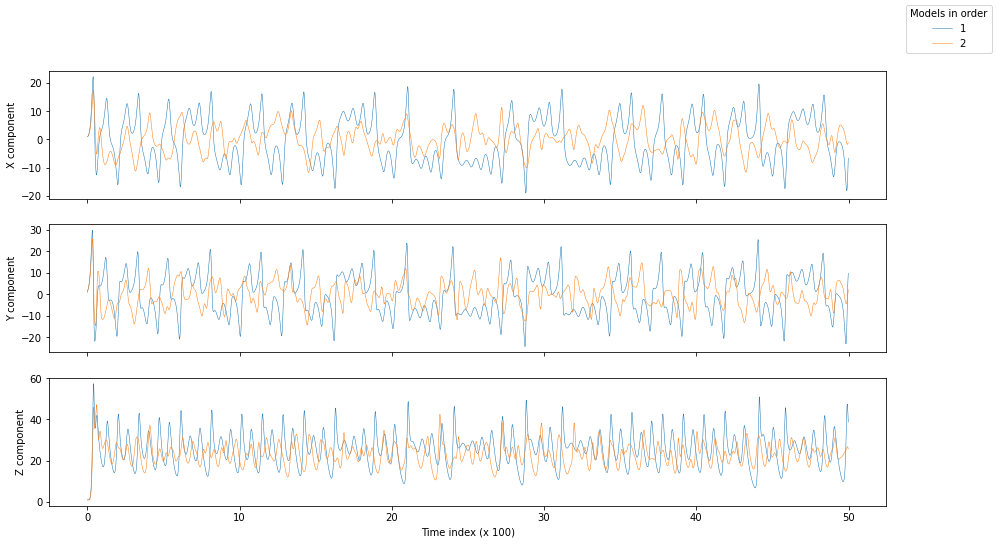

In [71]:
dts = [0.001, 0.01, 0.015]
ts = [10, 30, 50]

gt = generate_lorenz()


for dt in dts:
    for t in ts:
        gt = generate_lorenz(
            number_of_samples=int(t/dt),
            dt=dt
        )
        
        sm1 = generate_lorenz(
            sigma=13.25,
            rho=19,
            beta=3.5,
            number_of_samples=int(t/dt), 
            dt=dt
        )
        
        sm2 = generate_lorenz(
            sigma=7,
            rho=18,
            beta=3.7,
            number_of_samples=int(t/dt), 
            dt=dt
        )
        
        sm3 = generate_lorenz(
            sigma=6.5,
            rho=38,
            beta=1.7, 
            number_of_samples=int(t/dt), 
            dt=dt
        )
        
        mean_submodel = calc_mean_lorenz(np.array([
            sm1[0],
            sm2[0],
            sm3[0],
        ]))
        

        def observator(weights):
            return calc_weighted_average_lorenz(np.array([
                    sm1[0],
                    sm2[0],
                    sm3[0],
                ]),
                list(np.ravel(weights))
            )

        
        predicted_weights = assimilate_lorenz_weighted([1.,1.,1.], gt[0], observator)
        weighted_avg = calc_weighted_average_lorenz(
            np.array([
                    sm1[0],
                    sm2[0],
                    sm3[0],
                ]),
            predicted_weights
        )
        
        print(dt, t)
        print(error_metric(gt[0],mean_submodel))
        print(error_metric(gt[0], weighted_avg))
        plot_models([gt[0], mean_submodel], [gt[1], gt[1]])
        plot_models([gt[0], weighted_avg], [gt[1], gt[1]])


## Task 4. Create submodels

Now we will use the idea that some pretrained models can be connected to create new, better one. In this task you have to create 3 submodels with chosen by you \
init values. We hope you have some intuition after previous tasks so you can chose them wisely.

In [48]:
submodel_creator = set_submodel_consts(
    number_of_samples = 150,
    steps_4dvar = 10,
)

  Intermediate CurrentState at the current iteration: [ 1.    1.    1.   19.   13.25  3.5 ]
  Intermediate CurrentState at the current iteration: [ 1.37091882  1.47123081  0.90869483 19.17224042 13.31691246  2.72677295]
  Intermediate CurrentState at the current iteration: [ 2.25576887  2.60932583  0.4844923  20.04580477 13.50799213 -1.31961393]
  Intermediate CurrentState at the current iteration: [ 1.67008247  1.85601541  0.76527394 19.46758843 13.3815156   1.35870851]
  Intermediate CurrentState at the current iteration: [ 1.41352249  1.5260277   0.88827037 19.21430071 13.32611255  2.5319479 ]
  Intermediate CurrentState at the current iteration: [ 1.61246024  1.79154482  0.68189141 19.84847829 13.39358856  1.35966799]
  Intermediate CurrentState at the current iteration: [ 1.43576031  1.55570795  0.86520075 19.28519085 13.33365521  2.40090718]
  Intermediate CurrentState at the current iteration: [ 1.50689396  1.65458625  0.74254364 19.71888787 13.36451522  1.9454447 ]
  Intermedia

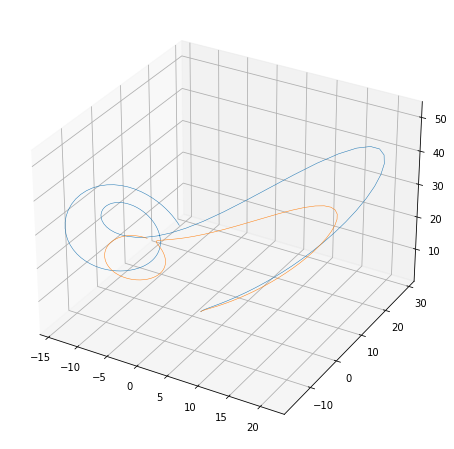

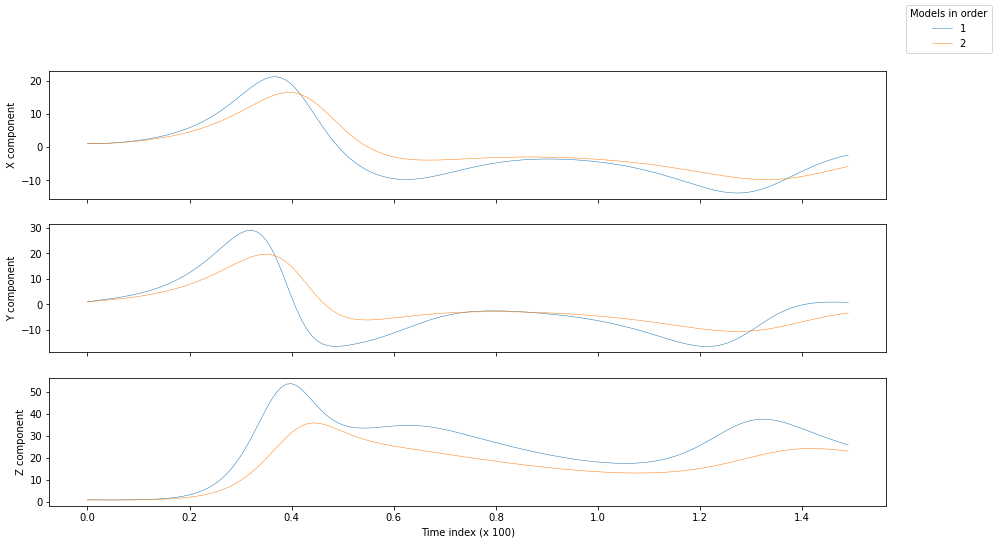

In [49]:
sm1 = submodel_creator(
    sigma=13.25,
    rho=19,
    beta=3.5,
    start_time=0
)

  Intermediate CurrentState at the current iteration: [ 1.   1.   1.  18.   7.   3.7]
  Intermediate CurrentState at the current iteration: [ 1.42850569  1.36547216  0.87315331 18.31565478  7.34971006  3.03307585]
  Intermediate CurrentState at the current iteration: [ 1.69573641  1.59482302  0.8467547  18.38459331  7.40755603  2.91349141]
  Intermediate CurrentState at the current iteration: [ 2.44294116  2.24057572  0.7786874  18.60462101  7.54641689  2.06204563]
  Intermediate CurrentState at the current iteration: [ 2.70351683  2.47644024  0.65982124 19.17323553  7.76942693  1.67911038]
  Intermediate CurrentState at the current iteration: [ 2.55868701  2.34534506  0.7258879  18.85719552  7.64547636  1.89194853]
  Intermediate CurrentState at the current iteration: [ 2.57288627  2.3655816   0.64781809 19.31720925  7.81092213  1.92780047]
  Intermediate CurrentState at the current iteration: [ 2.21405836  2.12226835  0.10506529 23.30778898  9.30396408  2.31468738]
  Intermediate Cur

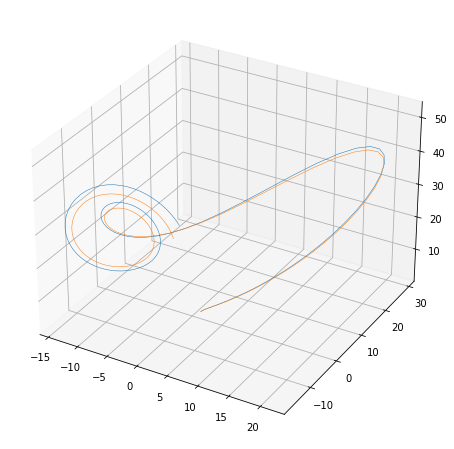

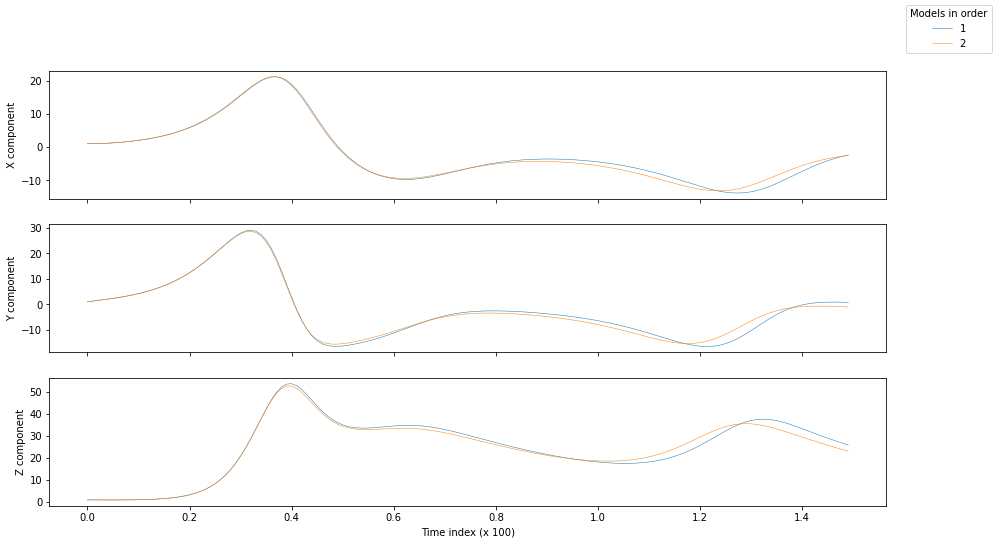

In [50]:
sm2 = submodel_creator(
    sigma=7,
    rho=18,
    beta=3.7,
    start_time=0
)

  Intermediate CurrentState at the current iteration: [ 1.   1.   1.  38.   6.5  1.7]
  Intermediate CurrentState at the current iteration: [ 0.37444733  0.68629614  1.10238582 37.64654076  6.31138936  1.11751954]
  Intermediate CurrentState at the current iteration: [ 0.83516052  0.91733585  1.0269797  37.9068599   6.45029918  1.54651048]
  Intermediate CurrentState at the current iteration: [ 0.69600597  0.84728343  1.06598138 37.73411634  6.45647929  1.17679586]
  Intermediate CurrentState at the current iteration: [ 0.79879216  0.89902749  1.03717288 37.86171297  6.45191437  1.44988471]
  Intermediate CurrentState at the current iteration: [ 0.83319719  0.9160014   1.05071166 37.80129666  6.48876744  1.40975463]
  Intermediate CurrentState at the current iteration: [ 0.91731193  0.95757352  1.09440981 37.6224954   6.59477018  1.38259843]
  Intermediate CurrentState at the current iteration: [ 0.9780331   0.9862591   1.18062957 37.29049705  6.76279186  1.35927401]
  Intermediate Cur

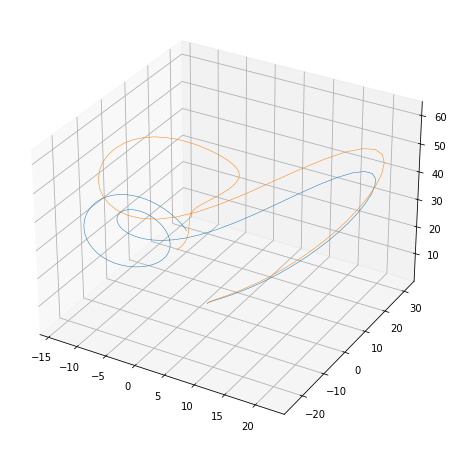

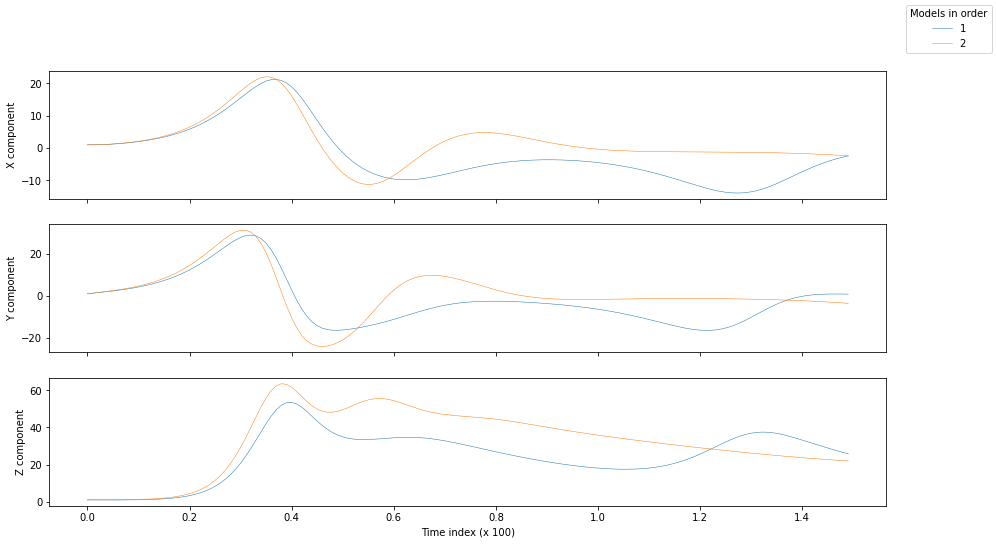

In [51]:
sm3 = submodel_creator(
    sigma=6.5,
    rho=38,
    beta=1.7,
    start_time=0
)

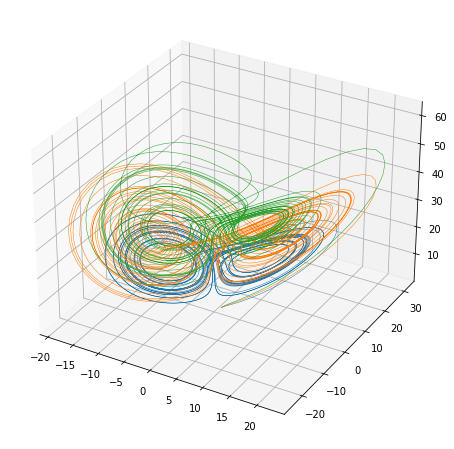

0.03162605599054987
0.026445720145690486
0.03367091622629535


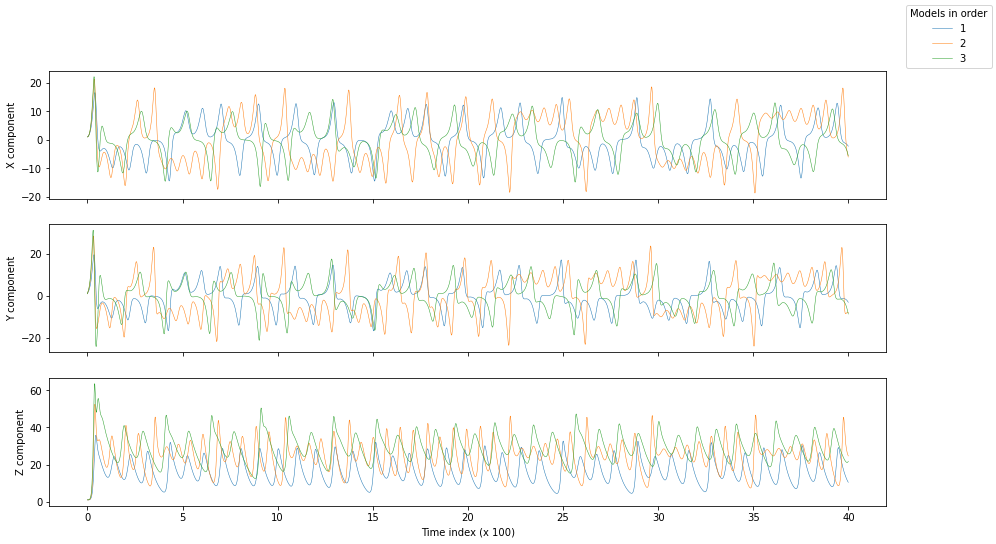

In [52]:
plot_models([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
],
[
    sm1['full']['pred'][1],
    sm2['full']['pred'][1],
    sm3['full']['pred'][1],
]
)

print(error_metric(sm1['full']['gt'][0], sm1['full']['pred'][0]))
print(error_metric(sm2['full']['gt'][0], sm2['full']['pred'][0]))
print(error_metric(sm3['full']['gt'][0], sm3['full']['pred'][0]))


0.023147173111827853


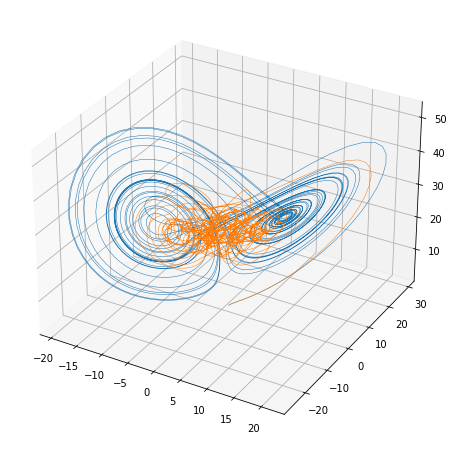

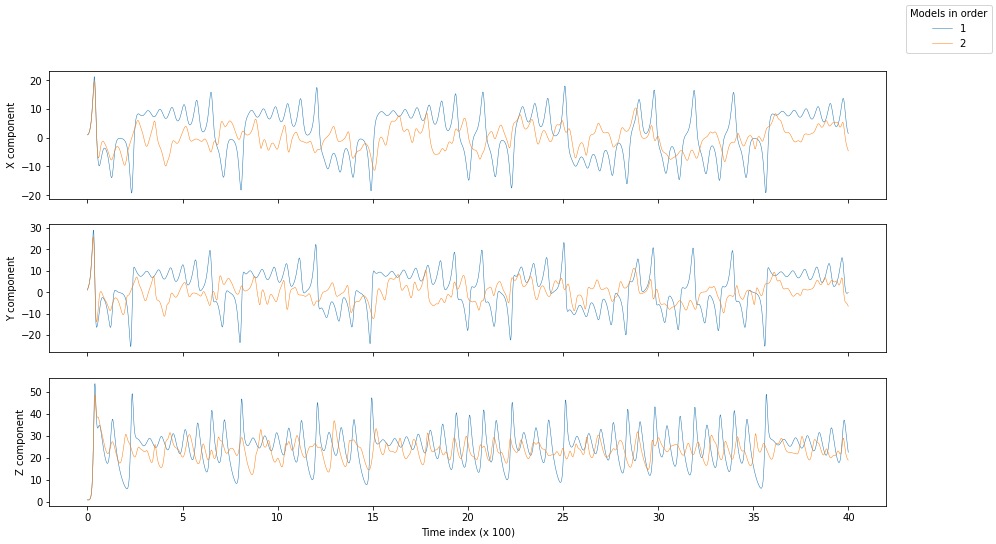

In [53]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

print(error_metric(sm1['full']['gt'][0],mean_submodel))
plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 5. Mean average from submodels

Some times one of your model can be better than others so its importance might be higher than others. Try to find best weights for weight average of your submodels.

In [ ]:
weights = [?,?,?]

mean_submodel = calc_weighted_average_lorenz(np.array([
        sm1['full']['pred'][0],
        sm2['full']['pred'][0],
        sm3['full']['pred'][0],
    ]),
    weights
)

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 6. 3d-var for weighted average from submodels

Now try to use 3D-Var to find best weights

In [54]:
def obertvator_kind(kind):
    def observator(weights):
        return calc_weighted_average_lorenz(np.array([
                sm1[kind]['pred'][0],
                sm2[kind]['pred'][0],
                sm3[kind]['pred'][0],
            ]),
            list(np.ravel(weights))
        )
    return observator


  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [1.3624441  0.18515684 1.45239906]
  Intermediate CurrentState at the current iteration: [1.12124152 0.72742604 1.15133244]
  Intermediate CurrentState at the current iteration: [1.11102625 0.72741135 1.16146888]
  Intermediate CurrentState at the current iteration: [1.11141144 0.72741282 1.16109264]
  Intermediate CurrentState at the current iteration: [1.11141159 0.72741212 1.16109295]
Calibration of 3 coefficients on 12000 measures
---------------------------------------------------------------------
Calibration resulting coefficients.: [1.11141159 0.72741212 1.16109295]
  Intermediate CurrentState at the current iteration: [1. 1. 1.]
  Intermediate CurrentState at the current iteration: [1.06794664 1.67068081 0.26137255]
  Intermediate CurrentState at the current iteration: [0.70877231 2.11328962 0.1816803 ]
  Intermediate CurrentState at the current iteration: [-0

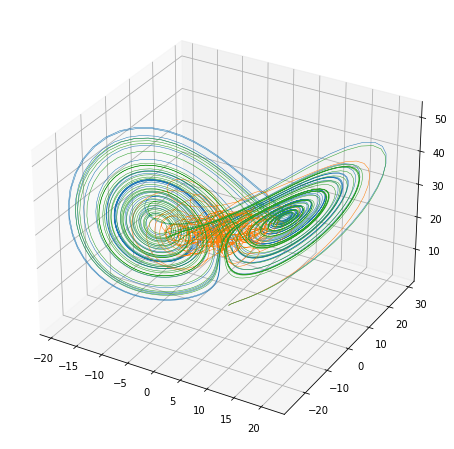

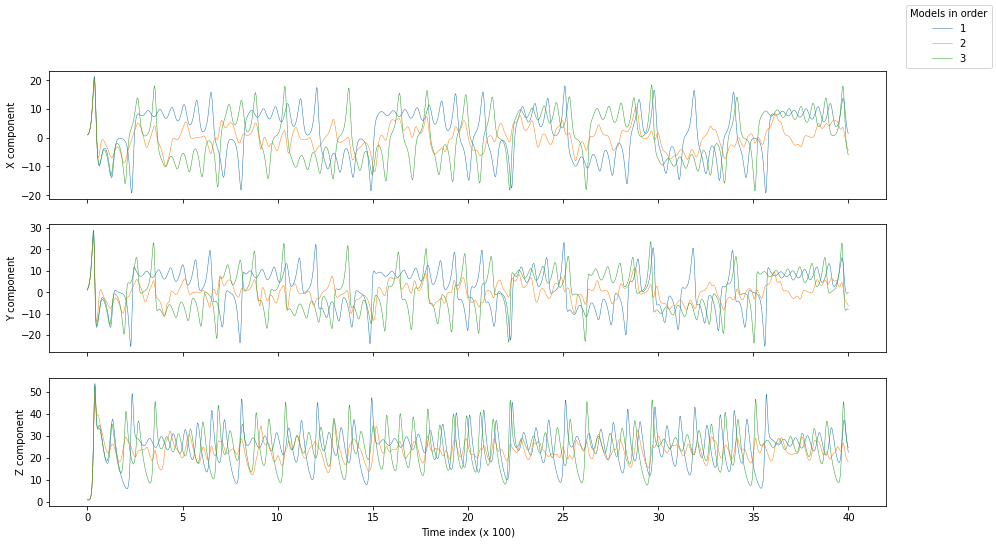

In [55]:
predicted_weights_full = assimilate_lorenz_weighted([1.,1.,1.], sm1['full']['gt'][0], obertvator_kind('full'))
predicted_weights_partial = assimilate_lorenz_weighted([1.,1.,1.], sm1['partial']['gt'][0], obertvator_kind('partial'))



weighted_avg_on_full = calc_weighted_average_lorenz(
    np.array([
            sm1['full']['pred'][0],
            sm2['full']['pred'][0],
            sm3['full']['pred'][0],
        ]),
    predicted_weights_full
    )

weighted_avg_on_partial = calc_weighted_average_lorenz(
    np.array([
            sm1['full']['pred'][0],
            sm2['full']['pred'][0],
            sm3['full']['pred'][0],
        ]),
    predicted_weights_partial
    )

print(error_metric(sm1['full']['gt'][0], weighted_avg_on_full))
print(error_metric(sm1['full']['gt'][0], weighted_avg_on_partial))

plot_models(
    [sm1['full']['gt'][0],
     weighted_avg_on_full, 
     weighted_avg_on_partial], 
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)

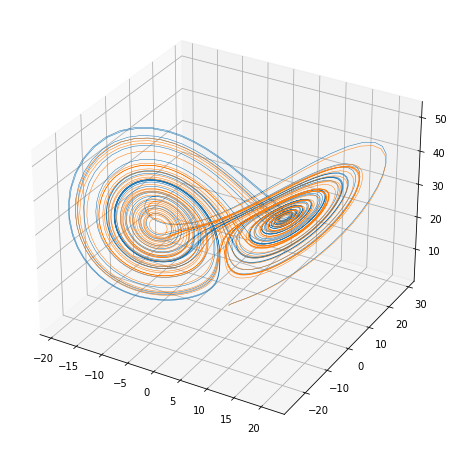

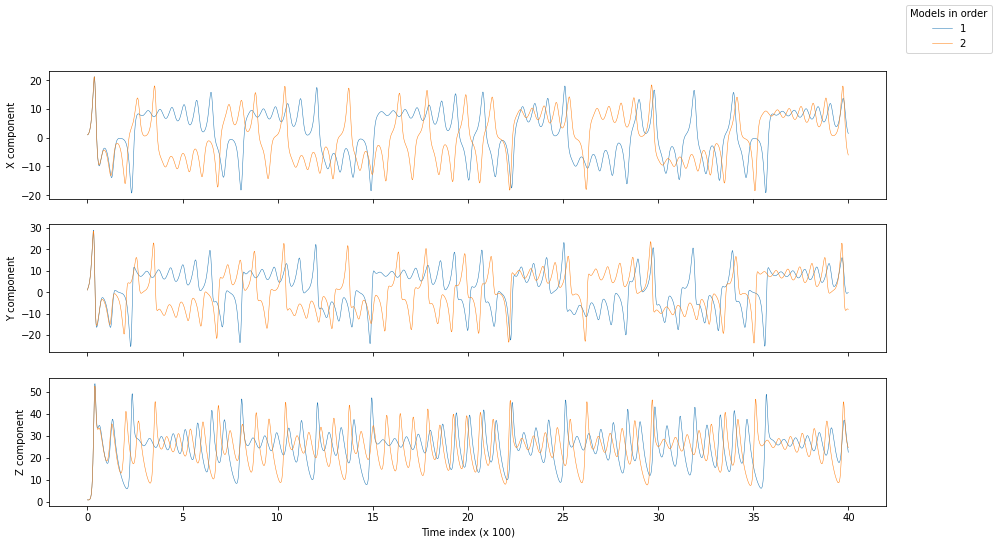

In [58]:
plot_models(
    [sm1['full']['gt'][0],
    weighted_avg_on_partial # put here your best weighted avg supermodel
    ], 
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)

## Task 7. Supermodeling

![](images/coupling.png)

source: Complex Systems Lecture

In [ ]:
def super_model_observator_kind(kind):
    def observator(springs):
        c12, c13, c21, c23, c31, c32 = list(np.ravel(springs))
        m1 = sm1[kind]['pred'][0].copy()
        m2 = sm2[kind]['pred'][0].copy()
        m3 = sm3[kind]['pred'][0].copy()
        x1 = m1[:, 0]
        x2 = m2[:, 0]
        x3 = m3[:, 0]
        m1[:, 0] += ???
        m2[:, 0] += ???
        m3[:, 0] += ???

        return calc_mean_lorenz(np.array([m1, m2,m3,]))
    return observator


predicted_springs_for_x = assimilate_lorenz_weighted([1., 1., 1., 1., 1., 1.], sm1['full']['gt'][0], super_model_observator_kind('full'))

In [ ]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

In [ ]:
springed_values = obertvator_kind('full')(predicted_springs_for_x)
plot_models(
    [sm1['full']['gt'][0],
    springed_values,
     mean_submodel,
    ],
    [sm1['full']['gt'][1],
     sm1['full']['gt'][1],
     sm1['full']['gt'][1]]
)